In [7]:
!unzip /content/lfw-deepfunneled.zip -d /content/


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0001.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0002.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0003.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Parad

In [8]:


import shutil
from shutil import unpack_archive
from subprocess import check_output
import keras


In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output


lfw_allnames = pd.read_csv("/content/dlfinal/lfw_allnames.csv")

print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images. The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) +
      ", with " +
      str(max(lfw_allnames.images)) +
      " unique images in the dataset.")

# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)


Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


<Axes: xlabel='name'>

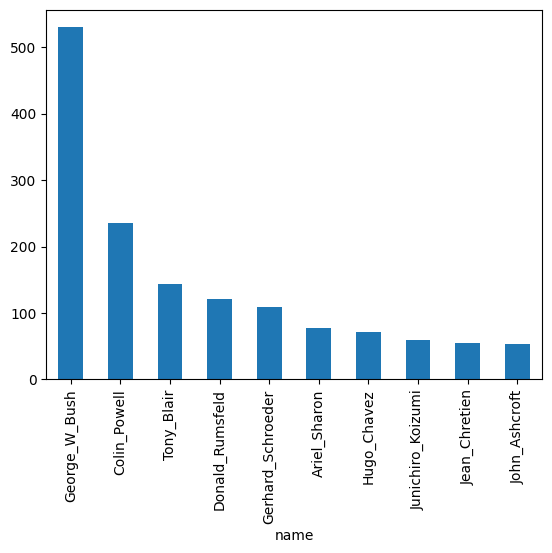

In [10]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")


In [11]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

Bush_classifier = Sequential()

initializer = GlorotUniform()

Bush_classifier.add(Conv2D(16, (5, 5), input_shape=(250, 250, 3), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

Bush_classifier.add(Conv2D(32, (4, 4), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

Bush_classifier.add(Conv2D(48, (3, 3), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

Bush_classifier.add(Flatten())

Bush_classifier.add(Dense(units=5000, activation='relu'))

Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [13]:

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/',dir_name,data_type))
        path_from = os.path.join('dlfinal/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/content/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [14]:

# define a custom function to move images to a new train/test/val directory
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set = train_datagen.flow_from_directory('Bush_train',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('Bush_val',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('Bush_test',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')


# Determine correct steps per epoch
steps_per_epoch = len(Bush_training_set)
validation_steps = len(Bush_val_set)

# Train the model
Bush_history = Bush_classifier.fit(
    Bush_training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=Bush_val_set,
    validation_steps=validation_steps
)

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Epoch 1/25
22/22 [==============================] - 17s 474ms/step - loss: 1.8397 - accuracy: 0.4735 - val_loss: 0.6906 - val_accuracy: 0.6000
Epoch 2/25
22/22 [==============================] - 11s 503ms/step - loss: 0.6896 - accuracy: 0.6047 - val_loss: 0.6846 - val_accuracy: 0.5765
Epoch 3/25
22/22 [==============================] - 11s 507ms/step - loss: 0.6615 - accuracy: 0.6401 - val_loss: 0.6496 - val_accuracy: 0.6118
Epoch 4/25
22/22 [==============================] - 11s 503ms/step - loss: 0.6077 - accuracy: 0.6504 - val_loss: 0.6676 - val_accuracy: 0.6176
Epoch 5/25
22/22 [==============================] - 10s 451ms/step - loss: 0.5664 - accuracy: 0.7389 - val_loss: 0.5788 - val_accuracy: 0.7059
Epoch 6/25
22/22 [==============================] - 10s 450ms/step - loss: 0.5290 - accuracy: 0.7404 - val_loss: 0.5431 - val_accuracy: 0.7176
Epoch 7/25
22/22 [=

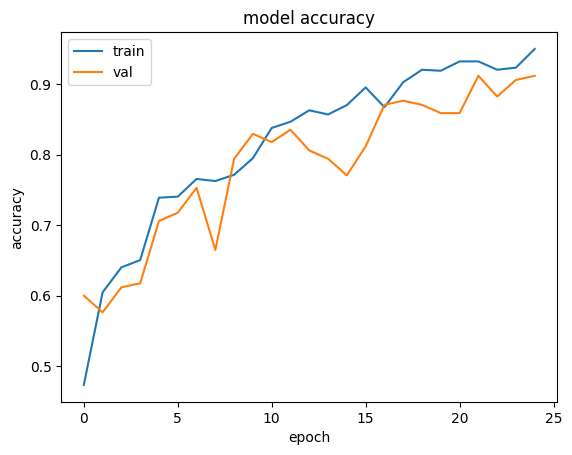

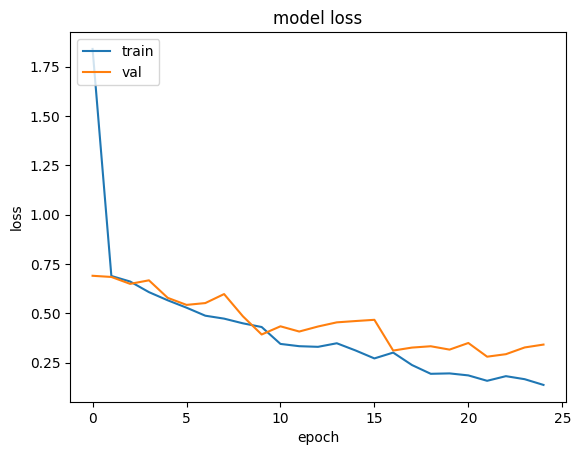

In [15]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:

Bush_classifier.save('Bush_classifier_25.h5')


from tensorflow.keras.models import load_model
model = load_model('Bush_classifier_25.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# use test data to make prediction and get the accuracy of the test dataset.
predictions = model.predict(Bush_test_set, steps=len(Bush_test_set))


loss, accuracy = model.evaluate(Bush_test_set, steps=len(Bush_test_set))

print("The loss value of the test dataset:", loss)
print("The accuracy value of the test dataset:", accuracy * 100)


7/7 [==============================] - 1s 49ms/step - loss: 0.2374 - accuracy: 0.9198
The loss value of the test dataset: 0.23735415935516357
The accuracy value of the test dataset: 91.98113083839417


For other people with multiple classes.

In [18]:
image_paths['name'].value_counts()[:6]

multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                    image_paths[image_paths.name=="Colin_Powell"].sample(75),
                    image_paths[image_paths.name=="Tony_Blair"].sample(75),
                    image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                    image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                    image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [19]:
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)

multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

multi_classifier.add(Dense(units = 6, activation = 'softmax'))

multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('train_multi',
                            target_size = (250, 250),
                            batch_size = 32,
                            class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('val_multi',
                            target_size = (250, 250),
                            batch_size = 32,
                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('test_multi',
                            target_size = (250, 250),
                            batch_size = 32,
                            class_mode = 'categorical')
steps_per_epoch_mul = len(multi_training_set)
validation_steps_mul = len(multi_val_set)

multi_history = multi_classifier.fit(multi_training_set,
                        steps_per_epoch = steps_per_epoch_mul,
                        epochs = 25,
                        validation_data = multi_val_set,
                        validation_steps = validation_steps_mul)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Epoch 1/25
9/9 [==============================] - 7s 368ms/step - loss: 25.8978 - accuracy: 0.1736 - val_loss: 9.8107 - val_accuracy: 0.2639
Epoch 2/25
9/9 [==============================] - 4s 437ms/step - loss: 7.1216 - accuracy: 0.2049 - val_loss: 3.3226 - val_accuracy: 0.2083
Epoch 3/25
9/9 [==============================] - 5s 528ms/step - loss: 2.2603 - accuracy: 0.3021 - val_loss: 2.1278 - val_accuracy: 0.2500
Epoch 4/25
9/9 [==============================] - 4s 430ms/step - loss: 1.7485 - accuracy: 0.3333 - val_loss: 1.6062 - val_accuracy: 0.4028
Epoch 5/25
9/9 [==============================] - 4s 433ms/step - loss: 1.5466 - accuracy: 0.3993 - val_loss: 1.6077 - val_accuracy: 0.3611
Epoch 6/25
9/9 [==============================] - 5s 608ms/s

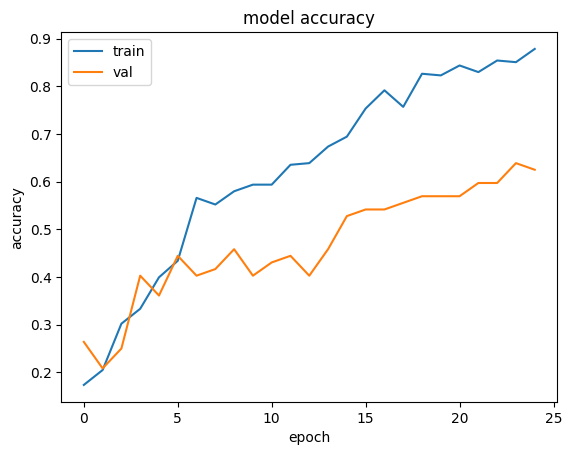

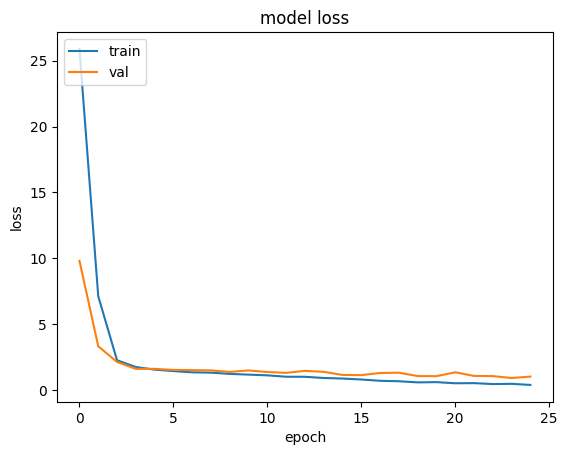

In [20]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
from keras.preprocessing import image
def mul_prediction(dir_name,classifier,binary):
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [22]:
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))


# Sharon_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')
# Powell_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')
# Rumsfeld_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')
# Bush_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')
# Schroeder_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')
# Blair_test_mul = test_datagen.flow_from_directory("test_multi/" + multi_test_name_order[0],target_size = (250, 250),batch_size = 32,class_mode = 'binary')


multi_predictions_0 = mul_prediction("test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = mul_prediction("test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = mul_prediction("test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = mul_prediction("test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = mul_prediction("test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = mul_prediction("test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


1/1 [==============================] - 0s 17ms/step


In [23]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                    [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                    columns = ['Predictions','Actual'])
def acc(predictions_frame):
    accuracy = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        accuracy.append((tp + tn)/total_preds)

    return accuracy

multi_accuracy = acc(multi_predictions_frame)
for i in range(len(multi_accuracy)):
    print(f"Test Accuracy for {multi_test_name_order[i]} is : {multi_accuracy[i]}")

Test Accuracy for Ariel_Sharon is : 0.9555555555555556
Test Accuracy for Colin_Powell is : 0.8333333333333334
Test Accuracy for Donald_Rumsfeld is : 0.8666666666666667
Test Accuracy for George_W_Bush is : 0.8444444444444444
Test Accuracy for Gerhard_Schroeder is : 0.9222222222222223
Test Accuracy for Tony_Blair is : 0.7555555555555555
